# Introdução

Na Lição 3 de * Detecção de Anomalia: Métodos Lineares *, aprendemos sobre métodos lineares 

Aqui, serão aplicadas todas as três técnicas para detectar anomalias em dados sintéticos e do mundo real.

# Resultados de Aprendizagem

Você deve sair deste tutorial Python com:
1. Experiência prática com modelos de regressão linear


# Importações

In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

import sys
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import sklearn.linear_model as linear_model
import sklearn.datasets as sk_data
from sklearn.preprocessing import StandardScaler
import numpy.linalg as nla
import sklearn.svm as svm
import pandas as pd

# Python and library versions

#1: Modelos de regressão linear

Nesta seção, vamos usar conjuntos de dados sintéticos para detectar anomalias usando uma regressão linear. Aplicaremos o que aprendemos a um conjunto de dados do mundo real nos exercícios.

A ideia principal: o desvio do modelo de regressão - ou seja, a diferença entre o valor real e o valor de previsão - é uma medida de quão anômalo é um ponto.

Um lembrete de como os modelos de regressão linear são usados para detecção de anomalias:

1. Divida os dados em conjuntos de dados de treinamento e teste
2. Use conjuntos de dados de trem para (i) obter os parâmetros do modelo de regressão e (ii) determinar o limite para anomalias
3. Aplique os resultados aos dados de teste para detectar anomalias


### Data

Aqui trabalharemos com os dados apresentados na aula expositiva: nota do exame e horas estudadas.

In [2]:
# Approximately linear data
exam_data1 = np.array([[1, 2, 3, 4, 5],
                    [57, 70, 76, 84, 91]]).T
print(exam_data1)

[[ 1 57]
 [ 2 70]
 [ 3 76]
 [ 4 84]
 [ 5 91]]


Para cada par de pontos de dados, o primeiro valor são as horas de estudos e o segundo é a nota do exame (em 100).

In [3]:
# One anomaly replaces a normal point
exam_data2 = np.array([[1, 2, 3, 4, 5],
                      [57, 70, 99, 84, 91]]).T
print(exam_data2)

[[ 1 57]
 [ 2 70]
 [ 3 99]
 [ 4 84]
 [ 5 91]]


A anomalia é  (3, 99).

Para simplificar nosso trabalho, vamos introduzir uma função auxiliar que plota uma linha reta dada a inclinação, interceptação, eixos (para criar a figura) e o estilo da linha (para plotar várias linhas no mesmo gráfico).

In [4]:
def plot_mb(m, b, ax, style):
    'plot a line y=mx+b on a matplotlib axis'
    xs = ax.get_xlim()
    ax.plot(xs, m*xs + b, style) #style is type of line

### Analise

Trace os dois conjuntos de dados juntos para que possamos compará-los facilmente.

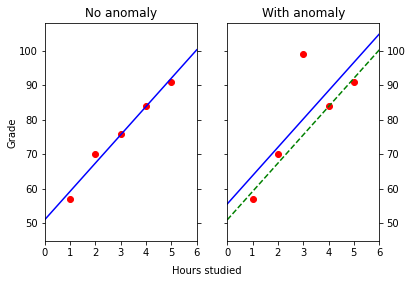

In [5]:
fig, axes = plt.subplots(1,2,sharex=True)

# Modify axes so they look nice
axes[0].set_xlim([0, 6.01])
start_x, end_x = axes[0].get_xlim()
stepsize_x = 1
axes[0].xaxis.set_ticks(np.arange(start_x, end_x, stepsize_x))
axes[0].yaxis.set_ticks_position('both')
axes[0].set_ylim([45, 108])
axes[1].set_ylim(axes[0].get_ylim())
axes[1].yaxis.tick_right() # Display tick values on the right for clarity
axes[1].yaxis.set_ticks_position('both')

# Fit a straight straight line to the linear data
lr = linear_model.LinearRegression().fit(exam_data1[:,0:1],
                                         exam_data1[:,1])
axes[0].plot(*exam_data1.T, 'ro')
plot_mb(lr.coef_, lr.intercept_, axes[0], 'b-' )

# Fit a straight straight line to data with anomaly
lr2 = linear_model.LinearRegression().fit(exam_data2[:,0:1],
                                         exam_data2[:,1])
axes[1].plot(*exam_data2.T, 'ro')

# Plot two linear fits: from data with anomaly and from normal data
plot_mb(lr2.coef_, lr2.intercept_, axes[1], 'b-')
plot_mb(lr.coef_, lr.intercept_, axes[1], 'g--')

axes[0].set_title('No anomaly')
axes[1].set_title('With anomaly')
fig.text(0.5, 0.02, 'Hours studied', ha='center', va='center')
fig.text(0.05, 0.5, 'Grade', ha='center', va='center', rotation='vertical')
plt.show()

Como podemos ver, todos os dados da esquerda estão próximos ao modelo de regressão (linha azul), enquanto que para os dados da direita podemos ver que há um ponto que está longe da linha. Este ponto (3, 99) é a anomalia.

** Nota: ** Existem duas linhas no painel à direita: o modelo de regressão para os dados com a anomalia (linha azul sólida) e aquele encontrado a partir dos dados normais do painel esquerdo (linha verde tracejada). A diferença entre essas duas linhas deve-se à própria anomalia (todos os outros pontos permanecem inalterados). Ou seja, as anomalias afetam o modelo de regressão.

É porque as anomalias afetam o modelo de regressão que fazemos a divisão de treinamento / teste para garantir que o ajuste linear reflita apenas os dados normais. Claro, tal abordagem presume que podemos ter (ou podemos criar) um conjunto de treinamento apenas com dados normais.   

Agora trataremos 'exam_data1' (sem anomalia) como o conjunto de dados do trem e 'exame_data2' (com anomalia) como o conjunto de dados de teste.

Primeiro, ajustamos nosso conjunto de dados de trem. Usaremos a função _LinearRegression_ de_sklearn_ como fizemos acima. A recuperação da pontuação da anomalia é o quadrado do resíduo de cada ponto.

In [6]:
ftrs, tgt = exam_data1[:,0:1], exam_data1[:,1]
lr_train = linear_model.LinearRegression().fit(ftrs, tgt)
print(f'Slope: {lr_train.coef_}')
print(f'Intercept: {lr_train.intercept_:.{3}}')
train_scores = (tgt - lr_train.predict(ftrs))**2 
print(train_scores)

Slope: [8.2]
Intercept: 51.0
[4.84 6.76 0.16 0.04 1.  ]


Vamos definir o limite para detecção de anomalias logo acima da pontuação máxima do conjunto de dados do trem.

In [7]:
margin = 0.01
threshold = max(train_scores) + margin
print(f'Threshold: {threshold:.{3}}')

Threshold: 6.77


Agora vamos calcular as pontuações de anomalia para os dados de teste.

In [8]:
def do_linreg_anomaly_scores(train, test):
    ftrs, tgt = train[:,0:1], train[:,1]
    lr_train = linear_model.LinearRegression().fit(ftrs, tgt)
    anom_score = (test[:,1] - lr_train.predict(test[:,0:1]))**2
    return anom_score

In [9]:
print(do_linreg_anomaly_scores(exam_data1, exam_data2))

[  4.84   6.76 547.56   0.04   1.  ]


Vemos que o ponto médio (índice = 2) excede o limite. É a anomalia que introduzimos nos dados. Como uma verificação, podemos comparar a pontuação de anomalia acima com os dados de treinamento.

In [10]:
print(train_scores)

[4.84 6.76 0.16 0.04 1.  ]


Como esperado, os dois conjuntos de pontuações diferem apenas para o ponto anômalo.